In [1]:

# Importar las librerías necesarias
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import seaborn as sns
import os
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Verificar si CUDA está disponible y configurar el dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")


Usando dispositivo: cuda


In [2]:

# Definir las transformaciones a aplicar a las imágenes
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Redimensionar imágenes a 128x128 píxeles
    transforms.ToTensor(),          # Convertir imágenes a tensores
])

# Ruta al directorio de imágenes
images_dir = '../last_data'

# Cargar el dataset de entrenamiento usando ImageFolder
train_dataset = datasets.ImageFolder(root=images_dir, transform=transform)

# Crear un DataLoader para manejar el batching y el shuffle
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Obtener los nombres de las clases a partir del dataset
class_names = train_dataset.classes
num_classes = len(class_names)
print(f"Clases encontradas: {class_names}")


Clases encontradas: ['Chinche salivosa', 'Clororis', 'Hoja sana', 'Roya naranja', 'Roya purpura']


C:\Users\ealda\AppData\Local\Temp\ipykernel_6808\2091522786.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_names, y=count_per_class, palette="viridis")


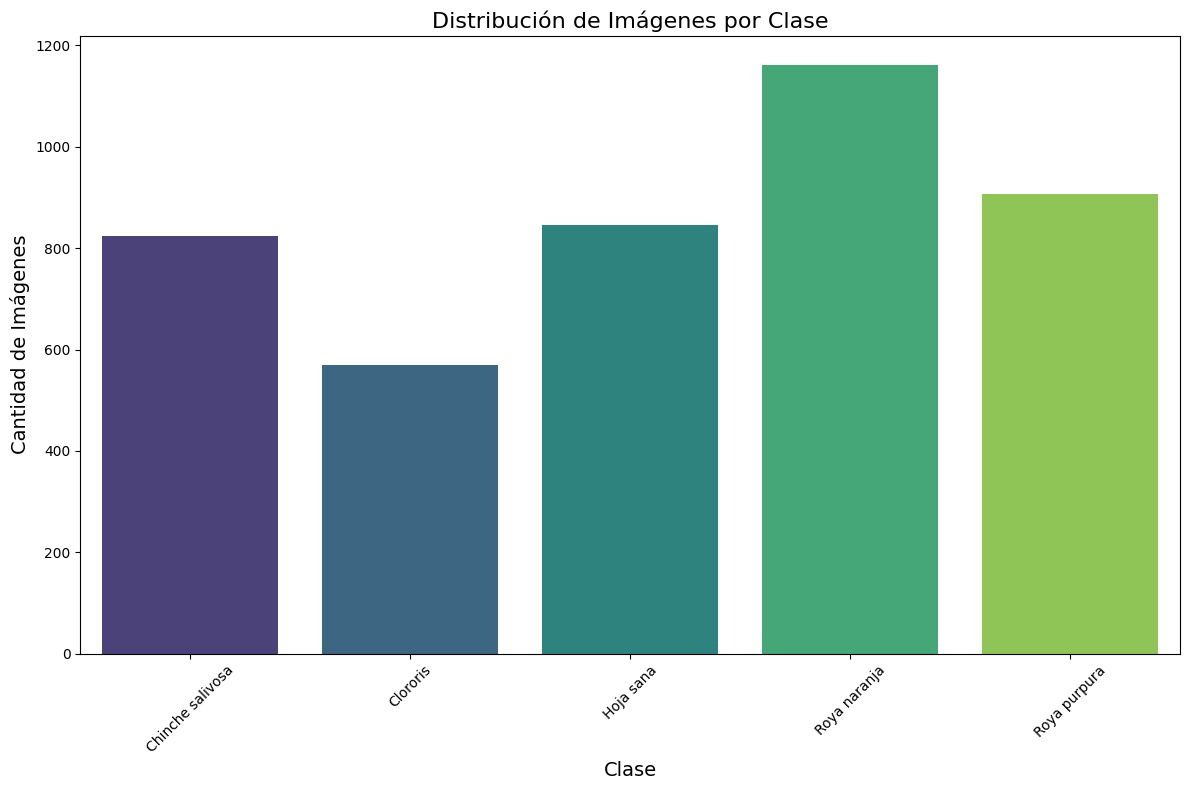

In [3]:

# Función para graficar la distribución de imágenes por clase
def plot_class_distribution(dataset, class_names):
    count_per_class = [0] * num_classes
    for _, label in dataset:
        count_per_class[label] += 1

    plt.figure(figsize=(12, 8))
    sns.barplot(x=class_names, y=count_per_class, palette="viridis")
    plt.xlabel('Clase', fontsize=14)
    plt.ylabel('Cantidad de Imágenes', fontsize=14)
    plt.title('Distribución de Imágenes por Clase', fontsize=16)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Mostrar la distribución de clases
plot_class_distribution(train_dataset, class_names)


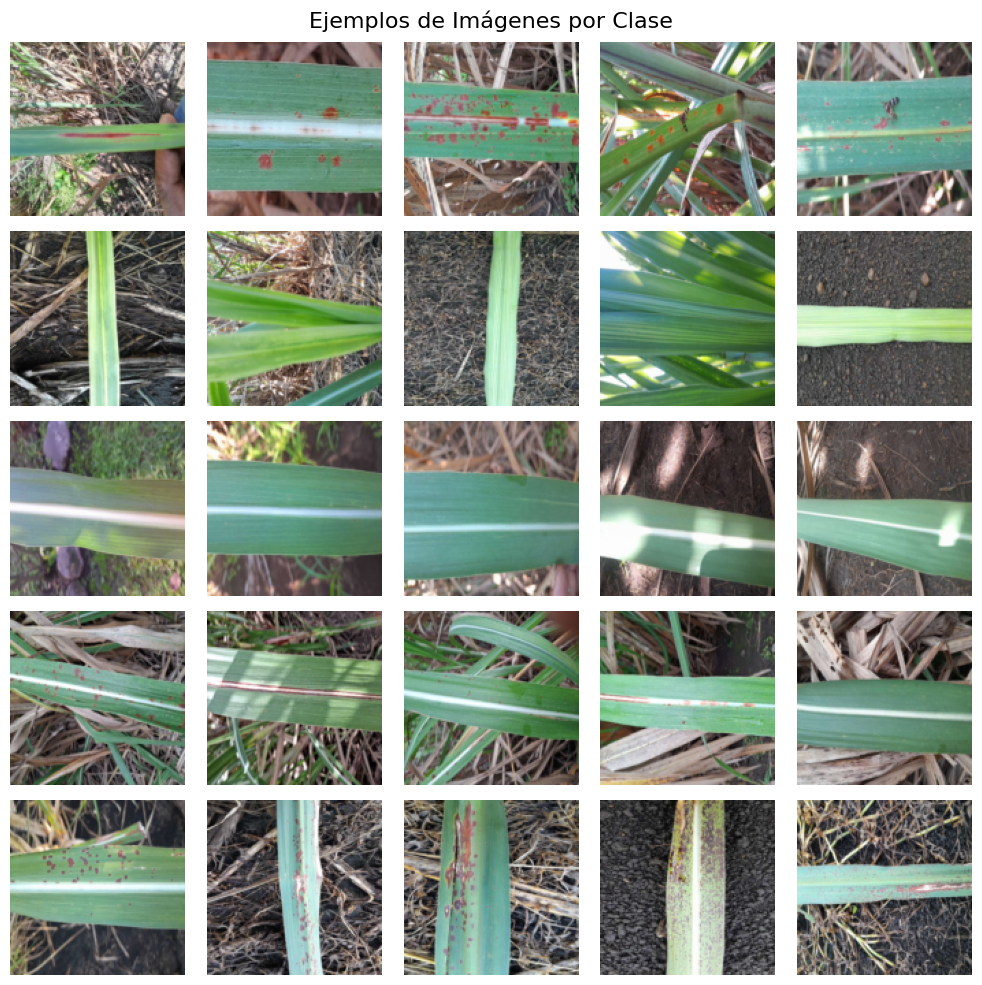

In [4]:

# Función para mostrar ejemplos de imágenes por clase
def visualize_samples_per_class(dataset, class_names, samples_per_class=5):
    samples = {class_name: [] for class_name in class_names}

    for image, label in dataset:
        class_name = class_names[label]
        if len(samples[class_name]) < samples_per_class:
            samples[class_name].append(image)
        if all(len(imgs) >= samples_per_class for imgs in samples.values()):
            break

    num_classes = len(class_names)
    plt.figure(figsize=(samples_per_class * 2, num_classes * 2))
    for idx, class_name in enumerate(class_names):
        for sample_idx in range(samples_per_class):
            ax = plt.subplot(num_classes, samples_per_class, idx * samples_per_class + sample_idx + 1)
            img = samples[class_name][sample_idx].permute(1, 2, 0).numpy()
            plt.imshow(img)
            plt.axis('off')
            if sample_idx == 0:
                plt.ylabel(class_name, fontsize=12)
    plt.suptitle('Ejemplos de Imágenes por Clase', fontsize=16)
    plt.tight_layout()
    plt.show()

# Visualizar ejemplos de imágenes por clase
visualize_samples_per_class(train_dataset, class_names)


Media por canal: tensor([0.4622, 0.5081, 0.4347])
Desviación estándar por canal: tensor([0.1759, 0.1919, 0.1874])


C:\Users\ealda\AppData\Local\Temp\ipykernel_6808\3355739252.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=channels, y=mean.numpy(), palette="coolwarm")
C:\Users\ealda\AppData\Local\Temp\ipykernel_6808\3355739252.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=channels, y=std.numpy(), palette="coolwarm")


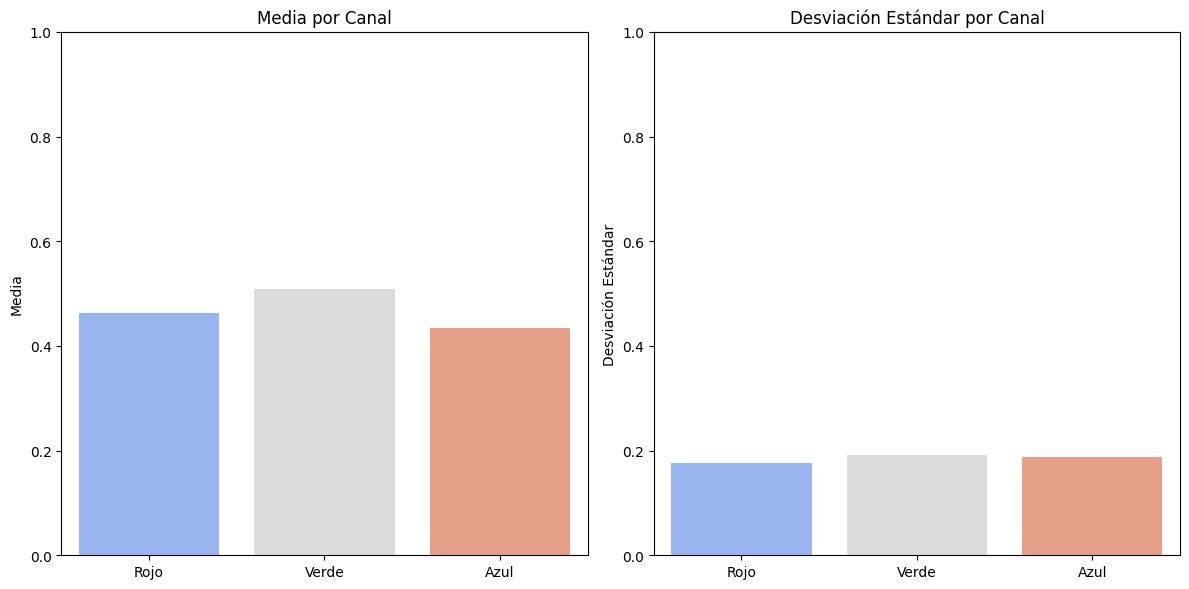

In [5]:

# Calcular estadísticas como media y desviación estándar por canal
def compute_image_statistics(dataset):
    loader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=2)
    mean = 0.
    std = 0.
    total_images = 0
    for images, _ in loader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images += batch_samples

    mean /= total_images
    std /= total_images

    print(f"Media por canal: {mean}")
    print(f"Desviación estándar por canal: {std}")

    channels = ['Rojo', 'Verde', 'Azul']
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    sns.barplot(x=channels, y=mean.numpy(), palette="coolwarm")
    plt.title('Media por Canal')
    plt.ylabel('Media')
    plt.ylim(0, 1)

    plt.subplot(1, 2, 2)
    sns.barplot(x=channels, y=std.numpy(), palette="coolwarm")
    plt.title('Desviación Estándar por Canal')
    plt.ylabel('Desviación Estándar')
    plt.ylim(0, 1)

    plt.tight_layout()
    plt.show()

# Calcular y mostrar estadísticas de las imágenes
compute_image_statistics(train_dataset)


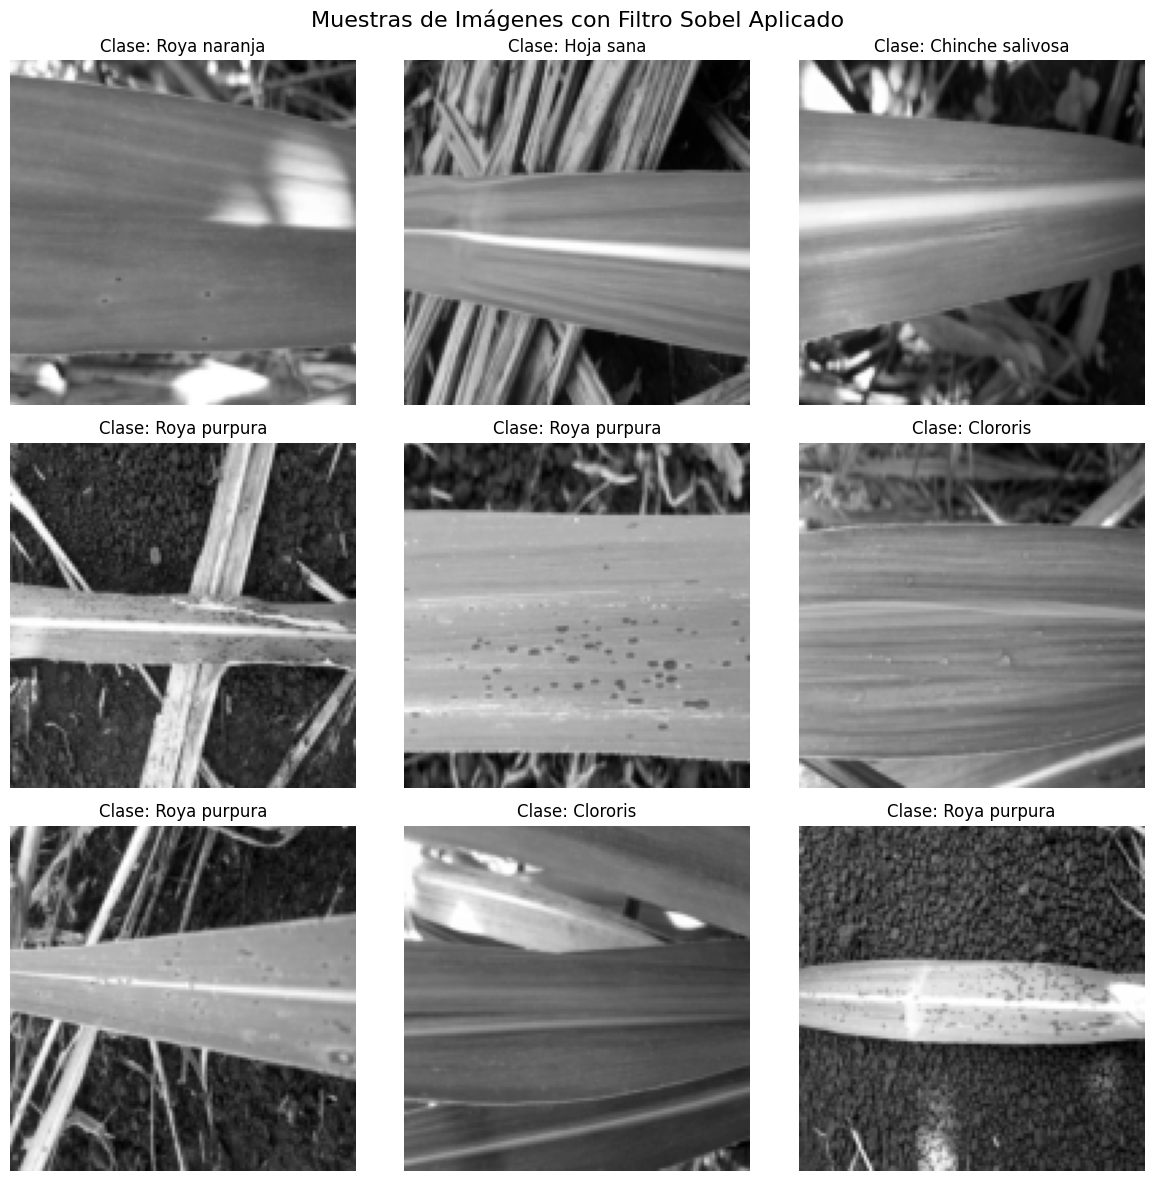

In [6]:

# Visualizar imágenes con filtro Sobel aplicado
def visualize_sobel_samples(dataset, class_names, samples=9):
    import torchvision.transforms.functional as F
    from PIL import Image
    from torchvision import transforms

    sobel_filter = transforms.Compose([
        transforms.Grayscale(),
        transforms.ToPILImage(),
        transforms.ToTensor(),
    ])

    indices = np.random.choice(len(dataset), samples, replace=False)
    plt.figure(figsize=(12, 12))
    for i, idx in enumerate(indices):
        image, label = dataset[idx]
        sobel_image = sobel_filter(image)
        sobel_image_np = sobel_image.squeeze().numpy()

        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(sobel_image_np, cmap='gray')
        plt.title(f"Clase: {class_names[label]}")
        plt.axis("off")
    plt.suptitle('Muestras de Imágenes con Filtro Sobel Aplicado', fontsize=16)
    plt.tight_layout()
    plt.show()

# Visualizar imágenes con filtro Sobel aplicado
visualize_sobel_samples(train_dataset, class_names, samples=9)


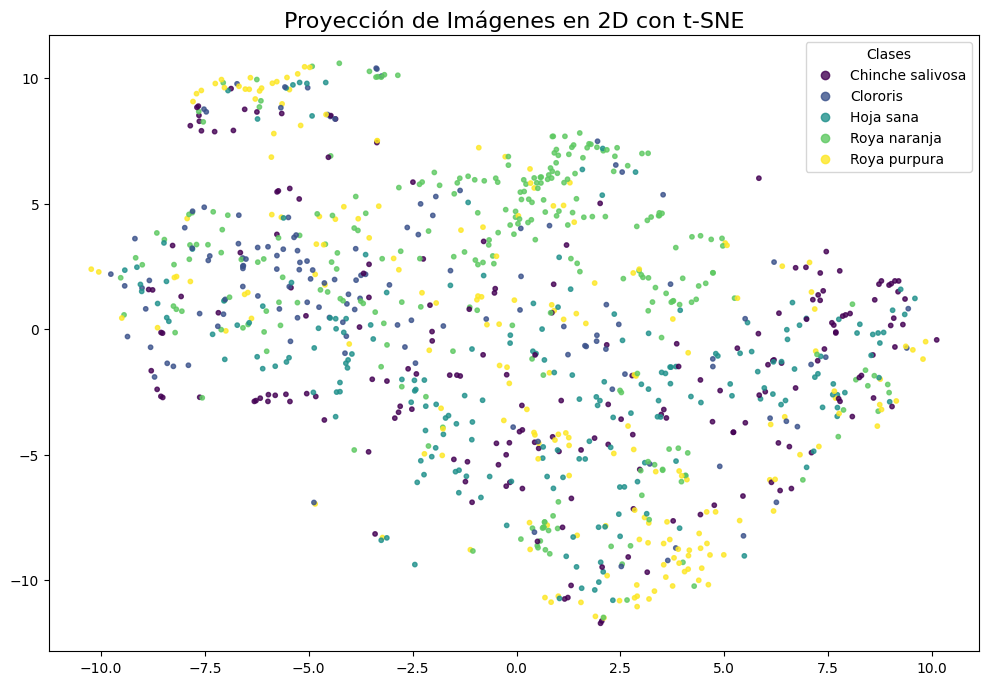

In [7]:

# Análisis avanzado: Proyección de imágenes en 2D con PCA y t-SNE
def visualize_latent_space(dataset, num_samples=1000):
    loader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=2)
    features = []
    labels = []

    for images, lbls in loader:
        batch_features = images.view(images.size(0), -1)
        features.append(batch_features)
        labels.extend(lbls.numpy())

        if len(labels) >= num_samples:
            break

    features = torch.cat(features)[:num_samples].numpy()
    labels = np.array(labels)[:num_samples]

    pca = PCA(n_components=50)
    features_pca = pca.fit_transform(features)

    tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
    features_tsne = tsne.fit_transform(features_pca)

    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=labels, cmap='viridis', s=10, alpha=0.8)
    plt.legend(handles=scatter.legend_elements()[0], labels=class_names, title="Clases")
    plt.title("Proyección de Imágenes en 2D con t-SNE", fontsize=16)
    plt.show()

# Visualizar la proyección de las imágenes en 2D
visualize_latent_space(train_dataset)


In [8]:

# Proporcionar un resumen del dataset
def dataset_summary(dataset):
    num_images = len(dataset)
    print(f"Total de imágenes en el dataset: {num_images}")
    print(f"Número de clases: {num_classes}")
    print(f"Clases: {class_names}")

# Mostrar resumen del dataset
dataset_summary(train_dataset)


Total de imágenes en el dataset: 4308
Número de clases: 5
Clases: ['Chinche salivosa', 'Clororis', 'Hoja sana', 'Roya naranja', 'Roya purpura']
